# Meta Inc. Stock price predictions

Let's take a look to stock prices and market capitalisation as a result of how market reacts to financial statistics of the company. 
First of all we need to extract financial statistics from the web. After that we need to determine affection of this statistics to stock price and discover correlation.
Final step will be building model to predict market capitalisation for the next quorter.

Import libraries

In [1]:
# Install if required
#!mamba install bs4==4.10.0 -y
#!mamba install html5lib==1.1 -y

In [2]:
#Import libraries for webscrapping
import pandas as pd
import requests
from bs4 import BeautifulSoup

Let's create function that will help us to extract data from macrotrends.net website. 

In [3]:
def get_dataframe_from_macrotrends_net(url, list_of_columns, table_number=0, column_index=1):
    # This function helps to get information from Macrotrends.net using simple navigation
    # You only need to enter url, list of parced columns in the table and 
    # number of the table (first, second ets in int format)

    html_data = requests.get(url).text   #get data from the webpage
    souped_html = BeautifulSoup(html_data, 'html5lib') #Use beautifulsoup

    # Find the second table with Quarterly Revenue /or use 0 for first table
    parced_table = souped_html.find_all('table')[table_number]   

    #Create blank dataframe 
    dataframe = pd.DataFrame(columns=list_of_columns) 
 
    # Find all tr tags and put data into Dataframe
    non_float_values = 0
    for row in parced_table.find("tbody").find_all("tr"):  

        col = row.find_all("td") 
        date = col[0].text 
        col1 = col[column_index].text
        col1 = col1.replace('$', '').replace(',', '')

        if col1.isdigit():
            col1 = float(col1)
            dataframe = dataframe.append({list_of_columns[0]:date, list_of_columns[1]:col1}, ignore_index=True)
        else: 
            dataframe = dataframe.append({list_of_columns[0]:date, list_of_columns[1]:col1}, ignore_index=True)
            non_float_values = non_float_values + 1
    
    print("Non float values:", non_float_values) #How many rows were missed
    return dataframe

Let's collect data: Revenue, Gross profit etc.

In [4]:
base_url = "https://www.macrotrends.net/stocks/charts/META/meta-platforms"
# Set list of tupples to parce
url_list = [(base_url + "/revenue", ["Date", "Revenue"], 1, 1),
            (base_url + "/gross-profit", ["Date", "Gross profit"], 1, 1),
            (base_url + "/eps-earnings-per-share-diluted", ["Date", "EPS"], 1, 1),
            (base_url + "/ebitda", ["Date", "EBITDA"], 1, 1),
            (base_url + "/operating-income", ["Date", "Operating income"], 1, 1),
            (base_url + "/pe-ratio", ["Date", "PE ratio"], 0, 3),
            (base_url + "/net-income", ["Date", "Net income"], 1, 1)
            ]

i=0
# Get dfs and join them to one dataframe
for url, list_of_cols, table_num, column_index in url_list: 
    #Get dataframe
    dataframe = get_dataframe_from_macrotrends_net(url, list_of_cols, table_num, column_index)
    
    # During first iterration resut df equals to dataframe
    if i == 0:
        result_df = dataframe
        
    # Second and other iterration we merge result df and dataframe we got with function
    else:
        result_df = result_df.merge(dataframe, how='left')
        
    i=i+1
    
revenue_df = result_df
revenue_df.head()

Non float values: 1
Non float values: 1
Non float values: 51
Non float values: 2
Non float values: 2
Non float values: 39
Non float values: 3


,Date,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income
0,2022-06-30,28822,23630,2.46,10337,8358,13.36,6687
1,2022-03-31,27908,21903,2.72,10680,8524,16.82,7465
2,2021-12-31,33671,27323,3.64,14599,12585,24.37,10285
3,2021-09-30,29010,23239,3.22,12418,10423,24.22,9194
4,2021-06-30,29077,23678,3.61,14353,12367,25.76,10394


In [5]:
revenue_df.shape

(51, 8)

In [6]:
revenue_df.dtypes

Date                object
Revenue             object
Gross profit        object
EPS                 object
EBITDA              object
Operating income    object
PE ratio            object
Net income          object
dtype: object

Now when revenue data extracted we need stocks price data.

## Extracting stock prices

I'm going to use Yahoo finance API to extract stock prices history.

In [7]:
# Import library
import yfinance as yf

# Set ticker
meta = yf.Ticker("META")

# Get history data
hist = meta.history(period="max")

hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,573576400,0,0
2012-05-21,36.529999,36.660000,33.000000,34.029999,168192700,0,0
2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600,0,0
2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000,0,0
2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200,0,0


Let's visualise data

<AxesSubplot:xlabel='Date'>

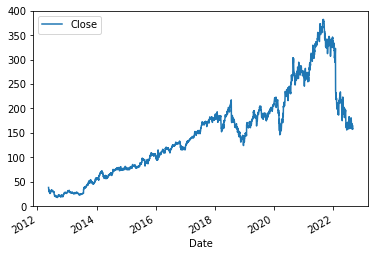

In [8]:
# Reset index
hist.reset_index(inplace=True)
# Plot the chart
hist.plot(x="Date", y="Close")

Now we need to join two dataframes. For this purposes I'll use this function

In [9]:
def join_price_and_revenue_dfs(price_df, revenue_df, shift=0):
    # Returns new dataframe after comparison of the dates. 

    # Import required libraries
    from datetime import datetime
    from datetime import timedelta
    
    # Set last day var to determine since what day stock prices is availiable
    last_history_date = hist.iloc[0,0]
    # Set time delta
    timedelta_object = timedelta(days=1)
    # Create blank list to collect prices from second df
    price_list =[]
    
    # Loop trought Revenue dataframe. 
    d1 = 0
    d2 = 0
    d3 = 0
    d4 = 0
        
    for index, row in revenue_df.iterrows():
        
        # Get date of the report. Then to exclude affection of the reports to the data
        # I'll use dates two days, three days and for days before the report.
        revenue_date = datetime.strptime(revenue_df.iloc[index, 0], "%Y-%m-%d")
        two_days_before_revenue_date = revenue_date - timedelta_object * 2
        three_days_before_revenue_date = revenue_date - timedelta_object * 3
        four_days_before_revenue_date = revenue_date - timedelta_object * 4
        
        # Check for revenue report days before IPO
        #if revenue_date < last_history_date:
        #    break
            
        # Search for report date in second dataframe the result returns in dataframe format
        price = 0
        df_with_price_4_days = price_df[price_df['Date']==four_days_before_revenue_date]
        df_with_price_3_days = price_df[price_df['Date']==two_days_before_revenue_date]
        df_with_price_2_days = price_df[price_df['Date']==two_days_before_revenue_date]
        df_with_price_0_days = price_df[price_df['Date']==revenue_date]
        
        # Check if dataframe is epty or not if not change price value
        # Priority to date 4 before report
        report_day = 0
        
        if len(df_with_price_0_days) > 0:
            price = df_with_price_0_days.iloc[0,4]
            report_day = 1
            
        if len(df_with_price_2_days) > 0:
            price = df_with_price_2_days.iloc[0,4]  
            report_day = 2
            
        if len(df_with_price_3_days) > 0:
            price = df_with_price_3_days.iloc[0,4] 
            report_day = 3
            
        if len(df_with_price_4_days) > 0:
            price = df_with_price_4_days.iloc[0,4]
            report_day = 4
        

        
        if report_day == 1:
            d1 = d1+1
        elif report_day == 2:
            d2 = d2+1
        elif report_day == 3:
            d3 = d3+1
        elif report_day == 4:
            d4 = d4+1
            
        
  #      Second variant with for loop (works much slower)      
  #      price = price_df[price_df['Date']==price_df.price_df[0,0]]
  #      if four_days_before_revenue_date
        
  #      for price_index, price_row in price_df.iterrows():
            # Get date from second dataframe
  #          price_date = price_df.iloc[price_index, 0]
            
  #          # If date(four days before report) found in prices DF then set 'price' var etc... 
  #          if price_date == four_days_before_revenue_date:
  #              price = price_df.iloc[price_index - 2, 4]
  #              i=1
  #          if price_date == three_days_before_revenue_date:
  #              price = price_df.iloc[price_index - 1, 4]
  #              i=2               
  #          if price_date == two_days_before_revenue_date:
  #              price = price_df.iloc[price_index, 4]
  #              i=3
  #          else:
  #              continue  
    
    
        # Built result dataframe    
        price_list.append(price)
    revenue_df['Price'] = price_list
    print("4 days enries: {}\n3 days enries: {}\n2 days enries: {}\n0 days enries: {}".format(d4, d3, d2, d1))
    print("Dataframe shape", revenue_df.shape)
    return revenue_df

Join dataframes using function

In [10]:
price_rev_df = join_price_and_revenue_dfs(hist, revenue_df)
price_rev_df.head()

4 days enries: 29
3 days enries: 12
2 days enries: 0
0 days enries: 0
Dataframe shape (51, 9)


,Date,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income,Price
0,2022-06-30,28822,23630,2.46,10337,8358,13.36,6687,160.679993
1,2022-03-31,27908,21903,2.72,10680,8524,16.82,7465,229.860001
2,2021-12-31,33671,27323,3.64,14599,12585,24.37,10285,346.179993
3,2021-09-30,29010,23239,3.22,12418,10423,24.22,9194,340.649994
4,2021-06-30,29077,23678,3.61,14353,12367,25.76,10394,355.640015


## Data preparation and exploration

First we need to cut off rows before the IPO date where 'Price' value is 0. 

In [11]:
#Filter df using values of Price column
clean_price_rev_df = price_rev_df[price_rev_df['Price']>0]
clean_price_rev_df.tail()

,Date,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income,Price
36,2013-06-30,1813,1348,0.13,792,562,108.17,331,24.160000
37,2013-03-31,1458,1045,0.09,606,373,1279.00,217,26.090000
38,2012-12-31,1585,1187,0.03,747,523,NaN,64,26.049999
39,2012-09-30,1262,940,-0.02,553,377,NaN,-59,20.620001
40,2012-06-30,1184,817,-0.08,-604,-743,NaN,-157,33.099998


Then we need check for data types and set it to proper. 

In [12]:
# Check for data types
clean_price_rev_df.dtypes

Date                 object
Revenue              object
Gross profit         object
EPS                  object
EBITDA               object
Operating income     object
PE ratio             object
Net income           object
Price               float64
dtype: object

In [13]:
#Change Date values to Datetext first because we can't change 2000-12 text to numeric format
clean_price_rev_df[['Date']] = clean_price_rev_df[['Date']].apply(pd.to_datetime)

#Change data types to Numeric
clean_price_rev_df = clean_price_rev_df.apply(pd.to_numeric)

#Change Date values from Numeric to Datetext again
clean_price_rev_df[['Date']] = clean_price_rev_df[['Date']].apply(pd.to_datetime)

/home/timur/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
# Check for data types
clean_price_rev_df.dtypes

Date                datetime64[ns]
Revenue                    float64
Gross profit               float64
EPS                        float64
EBITDA                     float64
Operating income           float64
PE ratio                   float64
Net income                 float64
Price                      float64
dtype: object

In [15]:
# Check for NaN values
clean_price_rev_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              41 non-null     datetime64[ns]
 1   Revenue           41 non-null     float64       
 2   Gross profit      41 non-null     float64       
 3   EPS               41 non-null     float64       
 4   EBITDA            41 non-null     float64       
 5   Operating income  41 non-null     float64       
 6   PE ratio          38 non-null     float64       
 7   Net income        41 non-null     float64       
 8   Price             41 non-null     float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.2 KB


As we can see PE ration has 3 NaN values lets replace it by mean value

In [16]:
# Replace NaN by Mean
clean_price_rev_df.fillna(value=clean_price_rev_df['PE ratio'].mean(), inplace=True)

The theory is that after the report date we should wait aproximately 3 month to see  how this report affected to the market price. So current report data will be used for predictions to the next 3 month.
For this purposes we need shif price column down to 1 row.

In [17]:
# Clone dataframe
price_rev_df_shifted = clean_price_rev_df 

In [18]:
# Shift price column
price_rev_df_shifted['Price'] = price_rev_df_shifted['Price'].shift(1)
price_rev_df_shifted.head()

,Date,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income,Price
0,2022-06-30,28822.0,23630.0,2.46,10337.0,8358.0,13.36,6687.0,NaN
1,2022-03-31,27908.0,21903.0,2.72,10680.0,8524.0,16.82,7465.0,160.679993
2,2021-12-31,33671.0,27323.0,3.64,14599.0,12585.0,24.37,10285.0,229.860001
3,2021-09-30,29010.0,23239.0,3.22,12418.0,10423.0,24.22,9194.0,346.179993
4,2021-06-30,29077.0,23678.0,3.61,14353.0,12367.0,25.76,10394.0,340.649994


Now it's time to explore our dataframe. Let's take a look to correlation between variables.

In [74]:
# Build correlation matrix
clean_price_rev_df.corr()

,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income,Price
Revenue,1.000000,0.999351,0.957176,0.972385,0.958794,-0.292468,0.950839,0.889512
Gross profit,0.999351,1.000000,0.960797,0.976668,0.964345,-0.299390,0.955033,0.892772
EPS,0.957176,0.960797,1.000000,0.990086,0.990158,-0.286533,0.999506,0.894400
EBITDA,0.972385,0.976668,0.990086,1.000000,0.998256,-0.299186,0.989004,0.902068
Operating income,0.958794,0.964345,0.990158,0.998256,1.000000,-0.296294,0.989972,0.892217
PE ratio,-0.292468,-0.299390,-0.286533,-0.299186,-0.296294,1.000000,-0.288899,-0.335888
Net income,0.950839,0.955033,0.999506,0.989004,0.989972,-0.288899,1.000000,0.897509
Price,0.889512,0.892772,0.894400,0.902068,0.892217,-0.335888,0.897509,1.000000


What do we realise here? There is strong correlation between varibles. I'm not surprized because that vars shows almoust same measure Income of the company. Strong correlation I mean value of correlation coefficien more than 90%. To automate process of determining vars that have strong correlation lets use function:

In [78]:
def get_vars_list_with_strong_correlation(dataframe):
    # Function returns list of vars that correlates to each  other with value of correlation
    # coefficien more then 90%
    
    # Create an empty list
    CorField = []
    
    # Count correlation coefficients
    CorrKoef=dataframe.corr()    
    
    # For each column in df
    for column_index in CorrKoef:
        
        # For each var index in filtered df where value more then 90%
        for var_index in CorrKoef.index[CorrKoef[column_index] > 0.9]:
            
            # Check if var index already in list and check for coefficient 
            # for same variable
            if column_index != var_index and var_index not in CorField and column_index not in CorField:
                CorField.append(var_index)
                print ("%s-->%s: r^2=%f" % (column_index,var_index, CorrKoef[column_index][CorrKoef.index==var_index].values[0]))
    return(CorField)           

In [80]:
# Get vars that has strong correlation
xx = get_vars_list_with_strong_correlation(clean_price_rev_df)
xx

Revenue-->Gross profit: r^2=0.999351
Revenue-->EPS: r^2=0.957176
Revenue-->EBITDA: r^2=0.972385
Revenue-->Operating income: r^2=0.958794
Revenue-->Net income: r^2=0.950839


['Gross profit', 'EPS', 'EBITDA', 'Operating income', 'Net income']

Now wee need to exclude 5 of this 6 vars. Let's take a look to correlation of this vars to 'Price'. As we can see strongest correlation with EBITDA. So we'll use EBITDA and PE ratio to our model.

## Linear model prediction

Since we have dataframe and know that there is linear correlation between <b>price</b> and <b>revenue</b> we can build linear regression model. Let's jump right in.

In [131]:
# Import libraries
import numpy as np
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Linear model algorithm
from sklearn import linear_model

Cut of first row with NaN and date column.

In [132]:
price_rev_df_shifted_without_first_row = price_rev_df_shifted[1:len(price_rev_df_shifted)]
price_rev_df_shifted_without_first_row.head()

,Date,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income,Price
1,2022-03-31,27908.0,21903.0,2.72,10680.0,8524.0,16.82,7465.0,160.679993
2,2021-12-31,33671.0,27323.0,3.64,14599.0,12585.0,24.37,10285.0,229.860001
3,2021-09-30,29010.0,23239.0,3.22,12418.0,10423.0,24.22,9194.0,346.179993
4,2021-06-30,29077.0,23678.0,3.61,14353.0,12367.0,25.76,10394.0,340.649994
5,2021-03-31,26171.0,21040.0,3.30,13350.0,11378.0,25.20,9497.0,355.640015


In [133]:
price_rev_first_row = price_rev_df_shifted[0:1]
price_rev_first_row

,Date,Revenue,Gross profit,EPS,EBITDA,Operating income,PE ratio,Net income,Price
0,2022-06-30,28822.0,23630.0,2.46,10337.0,8358.0,13.36,6687.0,NaN


Create train and test dataset

In [161]:
# Split test and train data
X = price_rev_df_shifted_without_first_row[['EBITDA', 'PE ratio']].values
Y = price_rev_df_shifted_without_first_row['Price'].values
                                           
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (32, 2) (32,)
Test set: (8, 2) (8,)


When train and test data splited build the model

In [162]:
# Built the model
regr = linear_model.LinearRegression()

regr.fit (X_train, y_train)

# The coefficients
print ('Coefficients: ', regr.coef_)
print('Intercept: ',regr.intercept_) 

Coefficients:  [ 0.01709512 -0.03437189]
Intercept:  54.283655339925076


In [167]:
# Predict values
y_test_predicted = regr.predict(X_test)

# Built df with actual and predicted values
actual_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_predicted}) 
print(actual_predicted)

print("\nResidual sum of squares: %.2f"
      % np.mean((y_test_predicted - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

       Actual   Predicted
0  118.010002  115.969915
1  153.589996  121.338244
2  116.139999  104.519219
3  355.640015  281.637316
4  208.100006  200.340890
5  166.949997  171.154781
6   88.010002   75.302306
7  180.110001  157.918237

Residual sum of squares: 923.45
Variance score: 0.85


In [170]:
from sklearn import metrics 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_predicted)) 
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_predicted)) 
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_predicted)))

Mean Absolute Error: 20.84733503146682
Mean Squared Error: 923.4529342108942
Root Mean Squared Error: 30.38836840323768


In [171]:
y_hat= regr.predict(price_rev_first_row[['EBITDA', 'PE ratio']])

In [181]:
print("Predicted price: ",y_hat, "Current price: ", hist.iloc[len(hist)-1, 4])

Predicted price:  [230.53668715] Current price:  158.5399932861328


## Conclusion

Now when we know predicted price we can use that information to make investment desigions. But this information only gives general veiw

Created by Timur Talikbayev